## Neural Network Models
____
GOALS:
* Model `price_actual` using a univariate XGBRegressor <br>
* Model all price components EXCEPT `price_day_ahead` with a multivariate XGBRegressor
___
OUTLINE:<br>
1. Import Libraries
2. Read in Data
3. Modeling `price_actual`<br>
    3.1 Prepare Data (Categoricals)<br>
    3.2 Split Data<br>
    3.3 Model one-to-one<br>
    3.4 Model 24-to-24<br>
    3.5 LSTM <br>
    3.6 LSTM-DNN <br>
4. Modeling Price Components (excluding `price_day_ahead`)<br>
    4.1 Model one-to-one<br>
    4.2 Model 24-to-24<br>
    4.3 LSTM <br>
    4.4 LSTM-DNN <br>
    
5. Final Model <br>
___

In [361]:
def window_gen(data, input_window, output_window, stride):
    '''
    Yields train and test samples of the given provided datasets, at specified input and out lengths, and specified strides
    
    PARAMETERS
    ----------
    train: tuple,
        Tuple of length 2, which provides the training features and training targets respectively
    test: tuple,
        Tuple of length 2, which provides the testing features and testing targets respectively
    input_window: int,
        Length of the sequence of input data
    output_window: int,
        Length of the sequence of output data
    stride, int
        Number of steps to move between first sample and second sample
    '''
    # Define X_train, y_train, X_test, y_test
    X, y = data[0], data[1]
    
    # Compute number of samples 
    n = len(X)/stride
    
    # If the input_window is greater than a day, X_train
    if input_window > 24:
        n_add = input_window - 24
        X = X.iloc[:n_add].append(X)
    else:
        n_add = 0
    for i in range(0, len(X)-n_add, stride):
        yield X.iloc[i:i+input_window].to_numpy(), y.iloc[i:i+output_window].to_numpy()
        
def resample(data, input_window, output_window, stride):
    win = window_gen((data[0], data[1]), input_window=input_window, output_window=output_window, stride=stride)
    
    n = int(len(data[0])/stride)
    X_data = np.array([])
    y_data = np.array([])
    
    for i in range(n):
        X_sample, y_sample = next(win)
        X_data = np.append(X_data, X_sample)
        y_data = np.append(y_data, y_sample)
        
    # Reshape
    X_data = X_data.reshape(n,input_window,len(data[0].columns))
    y_data = y_data.reshape(n, output_window)
    
    return X_data, y_data

In [362]:
def ensemble_nn(models):
    '''
    PARAMETERS
    ----------
    models: list,
        List containing trained models to use in ensemble
    RETURNS
    ----------
    ensemble: keras model,
        Trained model combining all input models into a single output model.
    '''
    # Get models in list
    models = [dnn, lstm]

    # Rename layers 
    for i, model in enumerate(models):
        for i2, layer in enumerate(model.layers):
            layer.trainable = False
            layer._name = f'ensemble_{i}_{i2}_{layer.name}'
    
    # Define multi-headed input
    ensemble_visible = [model.input for model in models]
    
    # Concatenate merge output from each model
    ensemble_outputs = [model.output for model in models]
    merge = layers.merge.concatenate(ensemble_outputs)
    hidden = layers.Dense(24, activation='relu')(merge)
    output = TimeDistributed(layers.Dense(1))(hidden)
    ensemble = keras.Model(inputs=ensemble_visible, outputs=output)   
    return ensemble

In [363]:
def compute_metrics(model, train, test):
    
    if type(train[0]) is not list:
        X_train = [train[0]]
        X_test = [test[0]]
    else:
        X_train = train[0]
        X_test = test[0]
    
    # Convert data into arrays if not already
    X_train = [np.array(x_data) for x_data in X_train]
    X_test = [np.array(x_data) for x_data in X_test]
    y_train, y_test = np.array(train[1]), np.array(test[1])
        
    # Convert data into arrays if not already
    #X_train, y_train = np.array(train[0]), np.array(train[1])
    #X_test, y_test = np.array(test[0]), np.array(test[1])
    
    # Predict 
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    
    # Compute sMAPE
    sMAPE_train = sMAPE(y_train.flatten(), preds_train.flatten())
    sMAPE_val = sMAPE(y_test.flatten(), preds_test.flatten())

    # Compute r2
    r2_train = r2(y_train.flatten(), preds_train.flatten())
    r2_val = r2(y_test.flatten(), preds_test.flatten())
    
    return [sMAPE_train, sMAPE_val, r2_train, r2_val]

### 1. Import Libraries

In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from keras import layers, models, regularizers

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.layers import TimeDistributed

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import os
import winsound
from sklearn.preprocessing import LabelEncoder
import datetime as dt

os.chdir('../scripts')
from functions import split_data, sMAPE, SMAPE, compute_metrics, r2,impute_immediate_mean
from functions import resample, plot_metric_range, compile_fit, ensemble_nn
os.chdir('../notebooks')


### 2. Read in Data

In [2]:
df_lag =pd.read_csv('../data/clean/df_clean_lag.csv', index_col=0, parse_dates=True)
TSO_preds = df_lag.price_day_ahead.copy()
y_true_train = df_lag.loc[:'2019', 'price_actual'].copy()
y_true_val = df_lag.loc['2020', 'price_actual'].copy()

### 3. Modeling
### 3.1 Prepare Data
Scale Continuous Data

In [3]:
continuous = df_lag.select_dtypes(exclude='object').drop(columns=['price_actual', 'price_day_ahead']).columns

# Get rid of negatives
time = dt.datetime(2021,3,24,22)
df_lag.loc[time, 'dew_point_bilbao_lag'] = impute_immediate_mean(df_lag['dew_point_bilbao_lag'], time)

# Rescale data [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
df_lag[continuous] = scaler.fit_transform(df_lag[continuous])

Encode and scale categoricals

In [4]:
# Get catergorical 
categorical = df_lag.select_dtypes(include='object').columns

# Get wind direction cols
wind_dirs = df_lag.filter(regex='wind(?!_speeds|_forecast)').columns

# Instantiate encoder and transfrom wind_dir cols
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df_lag['wind_madrid_lag'])
for col in wind_dirs:
    df_lag[col] = wind_dir_coder.transform(df_lag[col])
    
# Stack condition columns into single col
stacked_conditions = df_lag.filter(regex='condition').stack()

# Instantiate Label encoder, fit and transform on condition cols
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)
for col in df_lag.filter(regex='condition').columns:
    df_lag[col] = condition_coder.transform(df_lag[col])

# Rescale data [-1,1]
df_lag[categorical] = scaler.fit_transform(df_lag[categorical])

Split Data into training and validation

In [5]:
# Get price components to drop
price_drop = df_lag.filter(regex='price_(?!actual|day)').columns

# Split data
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')

Create results_actual dataframe

In [6]:
TSO_metrics = [
    'None',
    round(sMAPE(y_true_train, TSO_preds.loc[:'2019']),3),
    round(sMAPE(y_true_val, TSO_preds.loc['2020']),3), 
    round(r2(y_true_train, TSO_preds.loc[:'2019']),3),
    round(r2(y_true_val, TSO_preds.loc['2020']),3)
]
results_actual = pd.DataFrame({'TSO':TSO_metrics}, 
                              index=['Parameters','sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

### 3.3 Modeling (one-to-one)

In [7]:
# Define input_shape
input_shape = (X_train.shape[1],)

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(layers.Dense(1, activation='relu'))

# Compile and fit
nn1 = compile_fit(nn, (X_train,y_train), (X_val, y_val), patience=10,
                  loss = tf.keras.metrics.mean_absolute_error)

# Define params, compute metrics, add to table
params = {'Dense1':59,
          'Dense2':239,
          'Dense3':162,
          'Dense3':1}
results_actual['nn1'] = compute_metrics(nn1, params ,(X_train,y_train), (X_val, y_val))
results_actual.T

Epoch 1/200
1369/1369 [==============================] - 2s 1ms/step - loss: 2.0533 - SMAPE: 4.2205 - val_loss: 1.7293 - val_SMAPE: 4.9556
Epoch 2/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.4609 - SMAPE: 2.7884 - val_loss: 1.6846 - val_SMAPE: 4.9711
Epoch 3/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.3903 - SMAPE: 2.6555 - val_loss: 1.7918 - val_SMAPE: 5.1921
Epoch 4/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.3304 - SMAPE: 2.5408 - val_loss: 1.7195 - val_SMAPE: 5.0397
Epoch 5/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.3153 - SMAPE: 2.4981 - val_loss: 1.6497 - val_SMAPE: 4.9044
Epoch 6/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.2606 - SMAPE: 2.3966 - val_loss: 1.6181 - val_SMAPE: 4.7836
Epoch 7/200
1369/1369 [==============================] - 2s 1ms/step - loss: 1.2427 - SMAPE: 2.3587 - val_loss: 2.0592 - val_SMAPE: 6.0709
Epoch 8/200
1369/1369 [====

,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
TSO,None,16.03,16.922,0.954,0.971
nn1,"{'Dense1': 59, 'Dense2': 239, 'Dense3': 1}",3.283,3.87,0.986,0.98


The 1-to-1 model performed well, beating the TSO model in both SMAPE and r-squared on the validation set.  Let's remove `price_day_ahead` and see how it does.

### 3.5 Modeling (24-to-24)

Restructure data for 24 hour input and output

In [9]:
# Split the data into train and validation
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')

# Reorganize the training and testing data into batches
X_train, y_train = resample((X_train, y_train), 24, 24, 24)
X_val, y_val = resample((X_val,y_val), 24, 24, 24)

# Define input_shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and Fit
nn2 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

# Define parameters, compute metrics, add to table
params = {'Dense1':59,
          'Dense2':239,
          'Dense3':162,
          'TimeDistributed':1}
results_actual['nn2'] = compute_metrics(nn2, params, (X_train, y_train), (X_val, y_val))
results_actual.T

Epoch 1/200
58/58 [==============================] - 1s 6ms/step - loss: 11.5294 - SMAPE: 29.7080 - val_loss: 2.6049 - val_SMAPE: 7.2521
Epoch 2/200
58/58 [==============================] - 0s 4ms/step - loss: 2.0511 - SMAPE: 3.9545 - val_loss: 1.7437 - val_SMAPE: 4.7946
Epoch 3/200
58/58 [==============================] - 0s 4ms/step - loss: 2.1425 - SMAPE: 4.0857 - val_loss: 1.6637 - val_SMAPE: 4.8153
Epoch 4/200
58/58 [==============================] - 0s 4ms/step - loss: 1.7983 - SMAPE: 3.4619 - val_loss: 1.9711 - val_SMAPE: 5.6140
Epoch 5/200
58/58 [==============================] - 0s 4ms/step - loss: 1.6712 - SMAPE: 3.2338 - val_loss: 3.0562 - val_SMAPE: 8.3119
Epoch 6/200
58/58 [==============================] - 0s 4ms/step - loss: 1.8203 - SMAPE: 3.4523 - val_loss: 1.5975 - val_SMAPE: 4.5826
Epoch 7/200
58/58 [==============================] - 0s 4ms/step - loss: 1.6656 - SMAPE: 3.2238 - val_loss: 2.4966 - val_SMAPE: 7.0237
Epoch 8/200
58/58 [==============================] - 

,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
TSO,None,16.03,16.922,0.954,0.971
nn1,"{'Dense1': 59, 'Dense2': 239, 'Dense3': 1}",2.744,4.35,0.982,0.978
nn2,"{'Dense1': 59, 'Dense2': 239, 'Dense3': 162, '...",3.721,3.97,0.979,0.977


### Model (LSTM)

In [11]:
# Split the data into train and validation
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')

# Reorganize the training and testing data into batches
X_train, y_train = resample((X_train, y_train), 24, 24, 24)
X_val, y_val = resample((X_val,y_val), 24, 24, 24)

# Input Shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(60, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile Fit
nn3 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

# Append results
params = {'LSTM1':60,
          'LSTM2':24,
          'TimeDistributed':1,
          'input_win':'1-day'}

# Compute metrics and add to table
results_actual['nn3'] = compute_metrics(nn3, params, (X_train,y_train), (X_val,y_val))
results_actual.T

Epoch 1/200
58/58 [==============================] - 4s 29ms/step - loss: 52.4747 - SMAPE: 170.0770 - val_loss: 31.4742 - val_SMAPE: 130.5466
Epoch 2/200
58/58 [==============================] - 1s 19ms/step - loss: 47.9186 - SMAPE: 142.8279 - val_loss: 29.2232 - val_SMAPE: 114.7994
Epoch 3/200
58/58 [==============================] - 1s 22ms/step - loss: 46.0895 - SMAPE: 133.4357 - val_loss: 27.5843 - val_SMAPE: 104.3519
Epoch 4/200
58/58 [==============================] - 1s 20ms/step - loss: 44.4898 - SMAPE: 125.1387 - val_loss: 26.0365 - val_SMAPE: 95.1562
Epoch 5/200
58/58 [==============================] - 1s 21ms/step - loss: 42.9533 - SMAPE: 117.9142 - val_loss: 24.5477 - val_SMAPE: 86.8701
Epoch 6/200
58/58 [==============================] - 1s 20ms/step - loss: 41.4575 - SMAPE: 111.5837 - val_loss: 23.0996 - val_SMAPE: 79.2912
Epoch 7/200
58/58 [==============================] - 1s 21ms/step - loss: 39.9884 - SMAPE: 105.2001 - val_loss: 21.6942 - val_SMAPE: 72.3484
Epoch 8/20

Epoch 119/200
58/58 [==============================] - 1s 26ms/step - loss: 2.3354 - SMAPE: 4.3878 - val_loss: 2.7967 - val_SMAPE: 8.1557
Epoch 120/200
58/58 [==============================] - 2s 26ms/step - loss: 2.3179 - SMAPE: 4.3534 - val_loss: 2.8402 - val_SMAPE: 8.0956
Epoch 121/200
58/58 [==============================] - 1s 23ms/step - loss: 2.3461 - SMAPE: 4.4008 - val_loss: 2.7958 - val_SMAPE: 8.0258


,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
TSO,None,16.03,16.922,0.954,0.971
nn1,"{'Dense1': 59, 'Dense2': 239, 'Dense3': 1}",2.744,4.35,0.982,0.978
nn2,"{'Dense1': 59, 'Dense2': 239, 'Dense3': 162, '...",3.721,3.97,0.979,0.977
nn3,"{'LSTM1': 60, 'LSTM2': 24, 'TimeDistributed': ...",4.557,7.967,0.933,0.895


In [14]:
# Split the data into train and validation
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')

# Reorganize the training and testing data into batches
X_train, y_train = resample((X_train, y_train), 24*7, 24, 24)
X_val, y_val = resample((X_val,y_val), 24*7, 24, 24)

# Input Shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(60, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and Fit
nn4 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

# Append results
params = {'LSTM1':60,
          'LSTM2':24,
          'TimeDistributed':1,
          'input_win':'7-days'}

# Compute metrics and add to table
results_actual['nn4'] = compute_metrics(nn4, params, (X_train,y_train), (X_val,y_val))
results_actual.T

,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
TSO,None,16.03,16.922,0.954,0.971
nn1,"{'Dense1': 59, 'Dense2': 239, 'Dense3': 1}",2.744,4.35,0.982,0.978
nn2,"{'Dense1': 59, 'Dense2': 239, 'Dense3': 162, '...",3.721,3.97,0.979,0.977
nn3,"{'LSTM1': 60, 'LSTM2': 24, 'TimeDistributed': ...",4.557,7.967,0.933,0.895
nn4,"{'LSTM1': 60, 'LSTM2': 24, 'TimeDistributed': ...",6.24,9.812,0.883,0.843


In [15]:
# Input Shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and Fit
nn5 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

# Append results
params = {'LSTM1':83,
          'LSTM2':24,
          'TimeDistributed':1,
          'input_win':'7-days'}

# Compute metrics and add to table
results_actual['nn5'] = compute_metrics(nn5, params, (X_train,y_train), (X_val,y_val))
results_actual.T

Epoch 1/200
58/58 [==============================] - 8s 99ms/step - loss: 53.0665 - SMAPE: 173.6172 - val_loss: 32.2764 - val_SMAPE: 136.5677
Epoch 2/200
58/58 [==============================] - 5s 80ms/step - loss: 48.9403 - SMAPE: 148.5013 - val_loss: 30.2828 - val_SMAPE: 121.9762
Epoch 3/200
58/58 [==============================] - 5s 81ms/step - loss: 47.1511 - SMAPE: 138.7440 - val_loss: 28.6390 - val_SMAPE: 110.9816
Epoch 4/200
58/58 [==============================] - 5s 80ms/step - loss: 45.5500 - SMAPE: 130.4701 - val_loss: 27.0860 - val_SMAPE: 101.3201
Epoch 5/200
58/58 [==============================] - 5s 81ms/step - loss: 44.0100 - SMAPE: 123.1193 - val_loss: 25.5841 - val_SMAPE: 92.5810
Epoch 6/200
58/58 [==============================] - 5s 95ms/step - loss: 42.5075 - SMAPE: 115.5932 - val_loss: 24.1213 - val_SMAPE: 84.5892
Epoch 7/200
58/58 [==============================] - 6s 101ms/step - loss: 41.0329 - SMAPE: 109.6595 - val_loss: 22.6976 - val_SMAPE: 77.2637
Epoch 8/

58/58 [==============================] - 6s 100ms/step - loss: 2.4860 - SMAPE: 4.6744 - val_loss: 2.8137 - val_SMAPE: 8.0911
Epoch 119/200
58/58 [==============================] - 6s 106ms/step - loss: 2.4431 - SMAPE: 4.5597 - val_loss: 2.8170 - val_SMAPE: 8.0761
Epoch 120/200
58/58 [==============================] - 6s 101ms/step - loss: 2.4311 - SMAPE: 4.5569 - val_loss: 2.9772 - val_SMAPE: 8.4211
Epoch 121/200
58/58 [==============================] - 6s 98ms/step - loss: 2.4351 - SMAPE: 4.7070 - val_loss: 2.8617 - val_SMAPE: 8.1654
Epoch 122/200
58/58 [==============================] - 6s 98ms/step - loss: 2.4556 - SMAPE: 4.6422 - val_loss: 2.9756 - val_SMAPE: 8.4351
Epoch 123/200
58/58 [==============================] - 6s 97ms/step - loss: 2.4051 - SMAPE: 4.5632 - val_loss: 2.8037 - val_SMAPE: 7.9759
Epoch 124/200
58/58 [==============================] - 6s 102ms/step - loss: 2.3796 - SMAPE: 4.4703 - val_loss: 2.8493 - val_SMAPE: 8.1519
Epoch 125/200
58/58 [=======================

,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
TSO,None,16.03,16.922,0.954,0.971
nn1,"{'Dense1': 59, 'Dense2': 239, 'Dense3': 1}",2.744,4.35,0.982,0.978
nn2,"{'Dense1': 59, 'Dense2': 239, 'Dense3': 162, '...",3.721,3.97,0.979,0.977
nn3,"{'LSTM1': 60, 'LSTM2': 24, 'TimeDistributed': ...",4.557,7.967,0.933,0.895
nn4,"{'LSTM1': 60, 'LSTM2': 24, 'TimeDistributed': ...",6.24,9.812,0.883,0.843
nn5,"{'LSTM1': 83, 'LSTM2': 24, 'TimeDistributed': ...",4.413,7.982,0.941,0.894


In [28]:
# Input Shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(60, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

In [29]:
nn3 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

Epoch 1/200
58/58 [==============================] - 7s 80ms/step - loss: 53.9754 - SMAPE: 179.1431 - val_loss: 35.6774 - val_SMAPE: 148.6349
Epoch 2/200
58/58 [==============================] - 4s 69ms/step - loss: 50.0152 - SMAPE: 154.3059 - val_loss: 33.4253 - val_SMAPE: 131.5672
Epoch 3/200
58/58 [==============================] - 4s 68ms/step - loss: 48.1394 - SMAPE: 143.7396 - val_loss: 31.7212 - val_SMAPE: 119.7844
Epoch 4/200
58/58 [==============================] - 4s 68ms/step - loss: 46.5005 - SMAPE: 135.2807 - val_loss: 30.1331 - val_SMAPE: 109.5757
Epoch 5/200
58/58 [==============================] - 4s 69ms/step - loss: 44.9406 - SMAPE: 127.1814 - val_loss: 28.5983 - val_SMAPE: 100.3414
Epoch 6/200
58/58 [==============================] - 4s 69ms/step - loss: 43.4204 - SMAPE: 120.0789 - val_loss: 27.0997 - val_SMAPE: 91.8631
Epoch 7/200
58/58 [==============================] - 4s 68ms/step - loss: 41.9306 - SMAPE: 113.1782 - val_loss: 25.6314 - val_SMAPE: 84.0301
Epoch 8/

In [30]:
results_actual['nn3'] = compute_metrics(nn3,(X_train,y_train), (X_val,y_val))
results_actual

,TSO,nn1,nn2,nn3
sMAPE_train,16.030,2.910315,3.962906,6.398275
sMAPE_val,16.922,4.179681,3.454599,7.789913
r2_train,0.954,0.980623,0.983838,0.869208
r2_val,0.971,0.977432,0.980697,0.853570


In [ ]:
# Specify input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

# Compilte and Fit
nn4 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

# Compute metrics and add to table
results_actual['nn4'] = compute_metrics(nn4,(X_train,y_train), (X_val,y_val))
results_actual

In [32]:
nn4 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

Epoch 1/200
58/58 [==============================] - 9s 115ms/step - loss: 53.0826 - SMAPE: 173.9812 - val_loss: 34.9559 - val_SMAPE: 142.9651
Epoch 2/200
58/58 [==============================] - 6s 109ms/step - loss: 49.5362 - SMAPE: 150.9076 - val_loss: 33.0619 - val_SMAPE: 128.9688
Epoch 3/200
58/58 [==============================] - 7s 114ms/step - loss: 47.8252 - SMAPE: 141.9558 - val_loss: 31.4508 - val_SMAPE: 117.9920
Epoch 4/200
58/58 [==============================] - 6s 109ms/step - loss: 46.2551 - SMAPE: 133.8312 - val_loss: 29.9100 - val_SMAPE: 108.1947
Epoch 5/200
58/58 [==============================] - 7s 120ms/step - loss: 44.7333 - SMAPE: 126.7064 - val_loss: 28.4060 - val_SMAPE: 99.2231
Epoch 6/200
58/58 [==============================] - 6s 112ms/step - loss: 43.2401 - SMAPE: 118.9267 - val_loss: 26.9321 - val_SMAPE: 90.9449
Epoch 7/200
58/58 [==============================] - 6s 111ms/step - loss: 41.7710 - SMAPE: 112.6276 - val_loss: 25.4815 - val_SMAPE: 83.2552
Ep

In [34]:
results_actual['nn4'] = compute_metrics(nn4,(X_train,y_train), (X_val,y_val))
results_actual

,TSO,nn1,nn2,nn3,nn4
sMAPE_train,16.030,2.910315,3.962906,6.398275,29.473468
sMAPE_val,16.922,4.179681,3.454599,7.789913,15.500838
r2_train,0.954,0.980623,0.983838,0.869208,0.234718
r2_val,0.971,0.977432,0.980697,0.853570,0.365850


### 3.6 Model (LSTM-DNN)

In [16]:
# Split the data into train and validation
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')

# Get the x cols for lstm network, lagged cols
X_train_lstm = X_train.filter(regex='lag')
X_train_dnn = X_train.drop(columns=X_train_lstm.columns)

# Get the x cols for dnn network, forecast cols
X_val_lstm = X_val.filter(regex='lag')
X_val_dnn = X_val.drop(columns=X_val_lstm.columns)

# Reorganize the training and testing data into batches
X_train_dnn, y_train_dnn = resample((X_train_dnn, y_train), 24, 24, 24)
X_val_dnn, y_val_dnn = resample((X_val_dnn, y_val), 24, 24, 24)

# LSTM
X_train_lstm, y_train_lstm = resample((X_train_lstm, y_train), 24, 24, 24)
X_val_lstm, y_val_lstm = resample((X_val_lstm, y_val), 24, 24, 24)

# Specify input shape for dnn
input_shape = (X_train_dnn.shape[1], X_train_dnn.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and fit dnn
dnn = compile_fit(nn, (X_train_dnn, y_train_dnn), (X_val_dnn, y_val_dnn))

Epoch 1/200
58/58 [==============================] - 1s 7ms/step - loss: 12.9258 - SMAPE: 33.8020 - val_loss: 2.0069 - val_SMAPE: 7.4309
Epoch 2/200
58/58 [==============================] - 0s 5ms/step - loss: 2.8762 - SMAPE: 6.4971 - val_loss: 1.9000 - val_SMAPE: 6.2775
Epoch 3/200
58/58 [==============================] - 0s 5ms/step - loss: 2.8492 - SMAPE: 5.9981 - val_loss: 1.9445 - val_SMAPE: 5.8030
Epoch 4/200
58/58 [==============================] - 0s 5ms/step - loss: 2.4853 - SMAPE: 5.0428 - val_loss: 1.8522 - val_SMAPE: 5.6545
Epoch 5/200
58/58 [==============================] - 0s 5ms/step - loss: 2.4158 - SMAPE: 4.7639 - val_loss: 2.0548 - val_SMAPE: 6.0862
Epoch 6/200
58/58 [==============================] - 0s 5ms/step - loss: 2.2650 - SMAPE: 4.4600 - val_loss: 2.1696 - val_SMAPE: 6.4270
Epoch 7/200
58/58 [==============================] - 0s 5ms/step - loss: 2.2761 - SMAPE: 4.4573 - val_loss: 3.0143 - val_SMAPE: 8.2934
Epoch 8/200
58/58 [==============================] - 

In [17]:
# Specify shape for lstm
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train_lstm.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and fit lstm
lstm = compile_fit(nn, (X_train_lstm, y_train_lstm), (X_val_lstm, y_val_lstm))

Epoch 1/200
58/58 [==============================] - 4s 37ms/step - loss: 51.2939 - SMAPE: 162.8393 - val_loss: 31.0259 - val_SMAPE: 127.2584
Epoch 2/200
58/58 [==============================] - 2s 27ms/step - loss: 47.8606 - SMAPE: 141.7239 - val_loss: 29.3516 - val_SMAPE: 115.6471
Epoch 3/200
58/58 [==============================] - 2s 28ms/step - loss: 46.2993 - SMAPE: 134.1461 - val_loss: 27.8614 - val_SMAPE: 106.0632
Epoch 4/200
58/58 [==============================] - 2s 27ms/step - loss: 44.8218 - SMAPE: 126.7473 - val_loss: 26.4185 - val_SMAPE: 97.3674
Epoch 5/200
58/58 [==============================] - 2s 27ms/step - loss: 43.3815 - SMAPE: 119.8425 - val_loss: 25.0121 - val_SMAPE: 89.3987
Epoch 6/200
58/58 [==============================] - 2s 26ms/step - loss: 41.9516 - SMAPE: 113.5953 - val_loss: 23.5573 - val_SMAPE: 81.6373
Epoch 7/200
58/58 [==============================] - 1s 26ms/step - loss: 40.4186 - SMAPE: 106.6010 - val_loss: 22.0763 - val_SMAPE: 74.1975
Epoch 8/20

In [18]:
# Build combine dnn and lstm in ensemble neural network
ensemble = ensemble_nn([dnn, lstm])

# Compile and fit the ensemble network
nn6 = compile_fit(ensemble, ([X_train_dnn, X_train_lstm], y_train_dnn), ([X_val_dnn, X_val_lstm], y_val_dnn))

Epoch 1/200
58/58 [==============================] - 3s 21ms/step - loss: 29.4925 - SMAPE: 69.1477 - val_loss: 6.3737 - val_SMAPE: 16.9974
Epoch 2/200
58/58 [==============================] - 1s 10ms/step - loss: 7.8801 - SMAPE: 14.8873 - val_loss: 9.6204 - val_SMAPE: 24.8604
Epoch 3/200
58/58 [==============================] - 1s 11ms/step - loss: 3.9114 - SMAPE: 7.6440 - val_loss: 5.1135 - val_SMAPE: 14.5524
Epoch 4/200
58/58 [==============================] - 1s 12ms/step - loss: 2.4627 - SMAPE: 4.8456 - val_loss: 3.1878 - val_SMAPE: 9.2735
Epoch 5/200
58/58 [==============================] - 1s 13ms/step - loss: 2.1665 - SMAPE: 4.2100 - val_loss: 2.7010 - val_SMAPE: 7.8748
Epoch 6/200
58/58 [==============================] - 1s 12ms/step - loss: 2.1329 - SMAPE: 4.1971 - val_loss: 2.7133 - val_SMAPE: 7.8926
Epoch 7/200
58/58 [==============================] - 1s 11ms/step - loss: 2.1327 - SMAPE: 4.1674 - val_loss: 2.6508 - val_SMAPE: 7.7309
Epoch 8/200
58/58 [=======================

In [20]:
params = {'dnn':['Dense1 - 59','Dense2 - 239','Dense2 - 162', 'TimeDistributed - 1'],
          'lstm':['LSTM - 83', 'LSTM - 24','TimeDistributed - 1']}

results_actual['nn6'] = compute_metrics(nn6,
                                        params,
                                        ([X_train_dnn, X_train_lstm], y_train_dnn),
                                        ([X_val_dnn, X_val_lstm],y_val_dnn))
results_actual.T

,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
TSO,None,16.03,16.922,0.954,0.971
nn1,"{'Dense1': 59, 'Dense2': 239, 'Dense3': 1}",2.744,4.35,0.982,0.978
nn2,"{'Dense1': 59, 'Dense2': 239, 'Dense3': 162, '...",3.721,3.97,0.979,0.977
nn3,"{'LSTM1': 60, 'LSTM2': 24, 'TimeDistributed': ...",4.557,7.967,0.933,0.895
nn4,"{'LSTM1': 60, 'LSTM2': 24, 'TimeDistributed': ...",6.24,9.812,0.883,0.843
nn5,"{'LSTM1': 83, 'LSTM2': 24, 'TimeDistributed': ...",4.413,7.982,0.941,0.894
nn6,"{'dnn': ['Dense1 - 59', 'Dense2 - 239', 'Dense...",4.234,7.149,0.955,0.963


**Find Optimal DNN**

In [22]:
# Split the data into train and validation
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')

# Get the x cols for lstm network, lagged cols
X_train_lstm = X_train.filter(regex='lag')
X_train_dnn = X_train.drop(columns=X_train_lstm.columns)

# Get the x cols for dnn network, forecast cols
X_val_lstm = X_val.filter(regex='lag')
X_val_dnn = X_val.drop(columns=X_val_lstm.columns)

# Reorganize the training and testing data into batches
X_train_dnn, y_train_dnn = resample((X_train_dnn, y_train), 24, 24, 24)
X_val_dnn, y_val_dnn = resample((X_val_dnn, y_val), 24, 24, 24)

In [23]:
# Define input_shape
input_shape = (X_train_dnn.shape[1], X_train_dnn.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and Fit
dnn = compile_fit(nn, (X_train_dnn, y_train_dnn), (X_val_dnn, y_val_dnn))

params = {
    'Dense1':59,
    'Dense2':239,
    'Dense3':162,
    'TimeDistributed':1,
}
compute_metrics(dnn, params, (X_train_dnn, y_train_dnn), (X_val_dnn, y_val_dnn))

Epoch 1/200
58/58 [==============================] - 1s 6ms/step - loss: 10.2232 - SMAPE: 25.9317 - val_loss: 2.0234 - val_SMAPE: 6.9500
Epoch 2/200
58/58 [==============================] - 0s 4ms/step - loss: 2.8417 - SMAPE: 6.9592 - val_loss: 1.8433 - val_SMAPE: 6.2413
Epoch 3/200
58/58 [==============================] - 0s 4ms/step - loss: 2.7930 - SMAPE: 5.9195 - val_loss: 2.2850 - val_SMAPE: 6.4726
Epoch 4/200
58/58 [==============================] - 0s 4ms/step - loss: 2.6040 - SMAPE: 5.2516 - val_loss: 2.3266 - val_SMAPE: 6.7413
Epoch 5/200
58/58 [==============================] - 0s 4ms/step - loss: 2.4849 - SMAPE: 4.8491 - val_loss: 2.0624 - val_SMAPE: 6.2279
Epoch 6/200
58/58 [==============================] - 0s 4ms/step - loss: 2.5557 - SMAPE: 4.9518 - val_loss: 2.0965 - val_SMAPE: 6.2502
Epoch 7/200
58/58 [==============================] - 0s 4ms/step - loss: 2.3329 - SMAPE: 4.8340 - val_loss: 2.0499 - val_SMAPE: 6.1459
Epoch 8/200
58/58 [==============================] - 

[{'Dense1': 59, 'Dense2': 239, 'Dense3': 162, 'TimeDistributed': 1},
 5.403,
 5.089,
 0.961,
 0.971]

In [25]:
# Define input_shape
input_shape = (X_train_dnn.shape[1], X_train_dnn.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(184, activation='relu'))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and Fit
dnn1 = compile_fit(nn, (X_train_dnn, y_train_dnn), (X_val_dnn, y_val_dnn))

params = {
    'Dense1':59,
    'Dense2':184,
    'TimeDistributed':1,
}
compute_metrics(dnn1, params, (X_train_dnn, y_train_dnn), (X_val_dnn, y_val_dnn))

Epoch 1/200
58/58 [==============================] - 1s 4ms/step - loss: 21.3318 - SMAPE: 57.4670 - val_loss: 1.9528 - val_SMAPE: 7.1790
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 2.7912 - SMAPE: 6.2061 - val_loss: 1.8255 - val_SMAPE: 6.0815
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 2.5871 - SMAPE: 5.5212 - val_loss: 2.0126 - val_SMAPE: 6.0136
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 2.3944 - SMAPE: 4.8211 - val_loss: 2.0827 - val_SMAPE: 6.2232
Epoch 5/200
58/58 [==============================] - 0s 3ms/step - loss: 2.2884 - SMAPE: 4.5134 - val_loss: 2.1573 - val_SMAPE: 6.4496
Epoch 6/200
58/58 [==============================] - 0s 3ms/step - loss: 2.2530 - SMAPE: 4.3760 - val_loss: 2.0766 - val_SMAPE: 6.3123
Epoch 7/200
58/58 [==============================] - 0s 2ms/step - loss: 2.2033 - SMAPE: 4.2830 - val_loss: 2.5279 - val_SMAPE: 7.3094
Epoch 8/200
58/58 [==============================] - 

[{'Dense1': 59, 'Dense2': 184, 'TimeDistributed': 1},
 5.064,
 6.032,
 0.954,
 0.96]

In [26]:
# Define input_shape
input_shape = (X_train_dnn.shape[1], X_train_dnn.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(184, activation='relu', input_shape=input_shape))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and Fit
dnn2 = compile_fit(nn, (X_train_dnn, y_train_dnn), (X_val_dnn, y_val_dnn))

params = {
    'Dense1':184,
    'TimeDistributed':1,
}
compute_metrics(dnn2, params, (X_train_dnn, y_train_dnn), (X_val_dnn, y_val_dnn))

Epoch 1/200
58/58 [==============================] - 0s 4ms/step - loss: 30.7502 - SMAPE: 83.6909 - val_loss: 1.9972 - val_SMAPE: 7.1738
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 3.1367 - SMAPE: 6.8278 - val_loss: 1.8919 - val_SMAPE: 6.7974
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 2.7179 - SMAPE: 6.2400 - val_loss: 1.9459 - val_SMAPE: 6.4917
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 2.6290 - SMAPE: 5.8891 - val_loss: 1.8560 - val_SMAPE: 5.9709
Epoch 5/200
58/58 [==============================] - 0s 3ms/step - loss: 2.5100 - SMAPE: 5.3971 - val_loss: 1.7908 - val_SMAPE: 5.5446
Epoch 6/200
58/58 [==============================] - 0s 2ms/step - loss: 2.3995 - SMAPE: 4.9953 - val_loss: 2.2540 - val_SMAPE: 6.3752
Epoch 7/200
58/58 [==============================] - 0s 3ms/step - loss: 2.3212 - SMAPE: 4.6851 - val_loss: 2.0430 - val_SMAPE: 5.9659
Epoch 8/200
58/58 [==============================] - 

[{'Dense1': 184, 'TimeDistributed': 1}, 5.276, 5.556, 0.956, 0.967]

**Find Optimal LSTM**

Below, create resample the data in 1-14 day input windows and save the arrays in to data folder.  This way, will not have to resample each time want to change the input window.

In [35]:
for days in range(1,15):
    X_train_temp, y_train_temp = resample((X_train_lstm, y_train), 24*days, 24, 24)
    X_val_temp, y_val_temp = resample((X_val_lstm, y_val), 24*days, 24, 24)
    
    # Save data
    np.save(f'../data/nn_data/X_train_inputWin_{days}_days', X_train_temp)
    np.save(f'../data/nn_data/X_val_inputWin_{days}_days', X_val_temp)

Below, run lstm models with varying input_windows. Record results.

In [92]:
# Create dataframe to hold results
results_lstm = pd.DataFrame(index=['Input_window (days)','sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

# For each number of days in input window
for days in range(1,11):
    
    # Load resampled data
    X_train_lstm = np.load(f'../data/nn_data/X_train_inputWin_{days}_days.npy')
    X_val_lstm = np.load(f'../data/nn_data/X_val_inputWin_{days}_days.npy')

    # Specify shape for lstm
    input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

    # Instantiate model and build layers
    nn = models.Sequential()
    nn.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
    nn.add(layers.RepeatVector(y_train_lstm.shape[1]))
    nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
    nn.add(TimeDistributed(layers.Dense(1)))

    # Compile and fit lstm
    lstm = compile_fit(nn, (X_train_lstm, y_train_lstm), (X_val_lstm, y_val_lstm))
    results_lstm[days] = compute_metrics(lstm, days, (X_train_lstm, y_train_lstm), (X_val_lstm, y_val_lstm))
    
# Preview results
results_lstm.T

,Input_window (days),sMAPE_train,sMAPE_val,r2_train,r2_val
1,1.0,38.518,24.193,0.006,0.007
2,2.0,37.481,24.189,0.006,0.007
3,3.0,36.835,24.210,0.006,0.007
4,4.0,37.960,24.187,0.006,0.007
5,5.0,36.714,24.215,0.006,0.007
6,6.0,36.618,24.221,0.006,0.007
7,7.0,36.855,24.209,0.006,0.007
8,8.0,36.697,24.217,0.006,0.007
9,9.0,37.072,24.199,0.006,0.007
10,10.0,36.988,24.202,0.006,0.007


Changing the input window did not change the performance of the lstm at all. The r-squared value is very low because the range of predictions is very low. See the histogram below.

In [30]:
'''# Reorganize the training and testing data into batches
X_train_lstm, y_train_lstm = resample((X_train, y_train), 24*7, 24, 24)
#X_val_dnn, y_val_dnn = resample((X_val_dnn, y_val), 24, 24, 24)'''

In [42]:
'''# Split the data into train and validation
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')

# Get the x cols for lstm network, lagged cols
X_train_lstm = X_train.filter(regex='lag')
X_train_dnn = X_train.drop(columns=X_train_lstm.columns)

# Get the x cols for dnn network, forecast cols
X_val_lstm = X_val.filter(regex='lag')
X_val_dnn = X_val.drop(columns=X_val_lstm.columns)

# Reorganize the training and testing data into batches
X_train_lstm, y_train_lstm = resample((X_train_lstm, y_train), 24*7, 24, 24)
X_val_lstm, y_val_lstm = resample((X_val_lstm, y_val), 24*7, 24, 24)


# Specify shape for lstm
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train_lstm.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and fit lstm
lstm = compile_fit(nn, (X_train_lstm, y_train_lstm), (X_val_lstm, y_val_lstm))'''

Epoch 1/200
58/58 [==============================] - 7s 87ms/step - loss: 52.3703 - SMAPE: 169.3599 - val_loss: 32.5719 - val_SMAPE: 138.8301
Epoch 2/200
58/58 [==============================] - 5s 83ms/step - loss: 49.3716 - SMAPE: 150.7822 - val_loss: 30.8153 - val_SMAPE: 125.7232
Epoch 3/200
58/58 [==============================] - 5s 84ms/step - loss: 47.7239 - SMAPE: 141.8956 - val_loss: 29.2408 - val_SMAPE: 114.9059
Epoch 4/200
58/58 [==============================] - 5s 87ms/step - loss: 46.1768 - SMAPE: 133.8129 - val_loss: 27.7278 - val_SMAPE: 105.2313
Epoch 5/200
58/58 [==============================] - 6s 105ms/step - loss: 44.6694 - SMAPE: 126.2597 - val_loss: 26.2473 - val_SMAPE: 96.3691
Epoch 6/200
58/58 [==============================] - 6s 103ms/step - loss: 43.1880 - SMAPE: 119.1487 - val_loss: 24.7979 - val_SMAPE: 88.2241
Epoch 7/200
58/58 [==============================] - 6s 105ms/step - loss: 41.7276 - SMAPE: 112.4202 - val_loss: 23.3795 - val_SMAPE: 80.7190
Epoch 

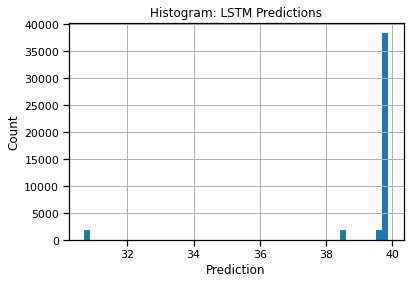

In [49]:
#preds = lstm.predict(X_train_lstm).flatten()
sns.set_context('notebook')
lstm_preds = pd.DataFrame({'lstm_preds':preds})
hist = lstm_preds.hist(bins=50);
plt.title('Histogram: LSTM Predictions');
plt.xlabel('Prediction');
plt.ylabel('Count');
plt.savefig('../images/LSTM_hist')

Now, since I have already run the Lasso models and noticed that the only other important variables other than `price_day_ahead` was were `humidities_bilbao_lag`, `oil_lag`, `renewable_lag`, `waste_lag`, I'll try a few model below with input_window = 24 and use only these columns as predictors.

In [89]:
days=1
lasso_cols = ['humidities_bilbao_lag', 'oil_lag', 'renewable_lag', 'waste_lag']

# Split the data into train and validation
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=price_drop), 2020, 'price_actual')

# Get the x cols for lstm network, lagged cols
X_train_lstm = X_train.loc[:,lasso_cols].copy()

# Get the x cols for dnn network, forecast cols
X_val_lstm = X_val.loc[:,lasso_cols].copy()

# Reorganize the training and testing data into batches
X_train_temp, y_train_temp = resample((X_train_lstm, y_train), 24*days, 24, 24)
X_val_temp, y_val_temp = resample((X_val_lstm, y_val), 24*days, 24, 24)

# Specify shape for lstm
input_shape = (X_train_temp.shape[1], X_train_temp.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train_lstm.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and fit lstm
lstm = compile_fit(nn, (X_train_temp, y_train_temp), (X_val_temp, y_val_temp))
print(compute_metrics(lstm, days, (X_train_temp, y_train_temp), (X_val_temp, y_val_temp)))

Epoch 1/200
58/58 [==============================] - 4s 28ms/step - loss: 51.9567 - SMAPE: 166.4658 - val_loss: 31.2894 - val_SMAPE: 129.1665
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 48.0381 - SMAPE: 143.7504 - val_loss: 29.3972 - val_SMAPE: 115.9520
Epoch 3/200
58/58 [==============================] - 1s 20ms/step - loss: 46.2801 - SMAPE: 134.2613 - val_loss: 27.7872 - val_SMAPE: 105.6032
Epoch 4/200
58/58 [==============================] - 1s 20ms/step - loss: 44.7031 - SMAPE: 126.2457 - val_loss: 26.2572 - val_SMAPE: 96.4296
Epoch 5/200
58/58 [==============================] - 1s 22ms/step - loss: 43.1816 - SMAPE: 119.1672 - val_loss: 24.7781 - val_SMAPE: 88.1183
Epoch 6/200
58/58 [==============================] - 1s 21ms/step - loss: 41.6962 - SMAPE: 112.3563 - val_loss: 23.3369 - val_SMAPE: 80.5021
Epoch 7/200
58/58 [==============================] - 1s 21ms/step - loss: 40.2358 - SMAPE: 106.2076 - val_loss: 21.9349 - val_SMAPE: 73.5100
Epoch 8/20

In [90]:
days=7

# Reorganize the training and testing data into batches
X_train_temp, y_train_temp = resample((X_train_lstm, y_train), 24*days, 24, 24)
X_val_temp, y_val_temp = resample((X_val_lstm, y_val), 24*days, 24, 24)

# Specify shape for lstm
input_shape = (X_train_temp.shape[1], X_train_temp.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train_lstm.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and fit lstm
lstm = compile_fit(nn, (X_train_temp, y_train_temp), (X_val_temp, y_val_temp), verbose=0)
print(compute_metrics(lstm, days, (X_train_temp, y_train_temp), (X_val_temp, y_val_temp)))

[7, 38.399, 24.191, 0.006, 0.007]


In [91]:
days=14

# Reorganize the training and testing data into batches
X_train_temp, y_train_temp = resample((X_train_lstm, y_train), 24*days, 24, 24)
X_val_temp, y_val_temp = resample((X_val_lstm, y_val), 24*days, 24, 24)

# Specify shape for lstm
input_shape = (X_train_temp.shape[1], X_train_temp.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train_lstm.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and fit lstm
lstm = compile_fit(nn, (X_train_temp, y_train_temp), (X_val_temp, y_val_temp), verbose=0)
print(compute_metrics(lstm, days, (X_train_temp, y_train_temp), (X_val_temp, y_val_temp)))

[14, 36.454, 24.231, 0.006, 0.007]


As shown above, using only the important columns from Lasso did not help the model improve.